# Continuous ensemble training
Now that the data, the network frameworks and the training loops are set up, we can investigate fruther.

# Setting everything up

In [11]:
# Reload module in case of changes
importlib.reload(utils)

<module 'lib.utils' from '/Users/floyd/Documents/Studium/BAE/continuous_training_using_ensemble_networks/notebooks/../lib/utils.py'>

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

import sys; sys.path.insert(0, '..')
import importlib

from lib import data, networks, training, utils

In [2]:
# load 10 class data
train_ds_pre, train_ds_post, test_ds, train_generator, test_generator = data.load_data(rotation=25)
dataset_shape = (tf.TensorSpec(shape=(28,28,1), dtype=tf.float64),
                tf.TensorSpec(shape=(10,), dtype=tf.float32),
                tf.TensorSpec(shape=(), dtype=tf.int32),
                tf.TensorSpec(shape=(10,), dtype=tf.float32))

num_classes = 10
# Small model
model1 = networks.NN([128, 128], num_classes)
# Broad Model
model2 = networks.NN([512], num_classes)
# Mixed Model
#model3a = networks.NN([256, 256], num_classes)

model3b = networks.CNN([(32, 3), (64, 5)])
# cnn
model4 = networks.CNN([(32, 3), (64, 5), (128, 7)], num_classes)
# cnn small
model5 = networks.CNN([(16, 3), (32, 3), (64, 5)], num_classes)
# ensemble
ensemble = networks.Ensemble([model1, model2, model3b, model4, model5])

model1.load_weights('../models/NN128128extra')
model2.load_weights('../models/NN512extra')
model3b.load_weights('../models/CNN3264extra')
model4.load_weights('../models/CNN3264128extra')
model5.load_weights('../models/CNN163264extra')

2022-05-30 12:52:45.042705: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
for m in ensemble.models:
    for x,y in test_ds.take(1):
        m(x)
    print(m.summary())

Model: "nn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  100480    
_________________________________________________________________
dense_1 (Dense)              multiple                  16512     
_________________________________________________________________
dense_2 (Dense)              multiple                  1290      
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________
None
Model: "nn_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              multiple                  401920    
_________________________________________________________________
dense_4 (Dense)              multiple                  5130      
Total params: 407,050
Trainable params:

# We need to get starting accuracies for some runs
- all jumps
- 0 rotation ensemble
- 0 rotation models

In [9]:
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
training.test(ensemble, test_generator, cross_entropy_loss)


(nan, 0.8785121487851215)

In [ ]:
jump_starting_accs = [0.9507049295070493,
                      0.943005699430057,
                      0.9074092590740926,
                      0.8785121487851215]

### How does the method react to different jumps in augmentation?

In [9]:
jumpfiles = ["Jump_r5_e1_b1_c24_d15000",
             "Jump_r10_e1_b1_c24_d15000",
             "Jump_r20_e1_b1_c24_d15000",
             "Jump_r25_e1_b1_c24_d15000"]

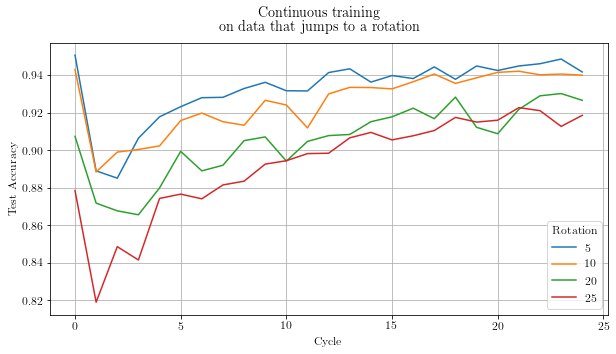

In [147]:
utils.plot_multiple_ensemble_accuracies(jumpfiles, "Jump")

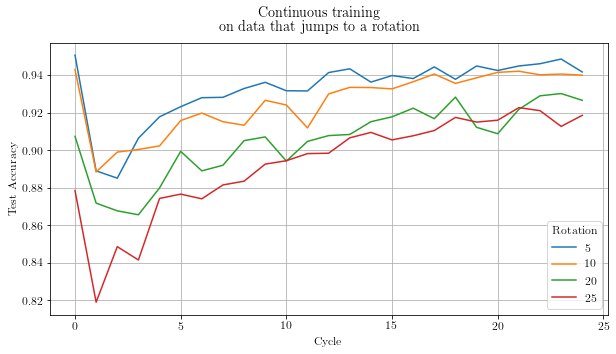

In [140]:
utils.plot_multiple_ensemble_accuracies(jumpfiles, "Jump")

### What augmentation speeds can the method handle?

In [4]:
files = ["Increment_r180_e1_b1_c36_d15000",
         "Increment_r180_e1_b1_c60_d15000", 
         "Increment_r180_e1_b1_c90_d15000", 
         "Increment_r90_e1_b1_c90_d15000", 
         "Increment_r180_e1_b1_c360_d15000",
         "Increment_r30_e1_b1_c90_d15000",
         "Increment_r180_e1_b1_c900_d15000"]

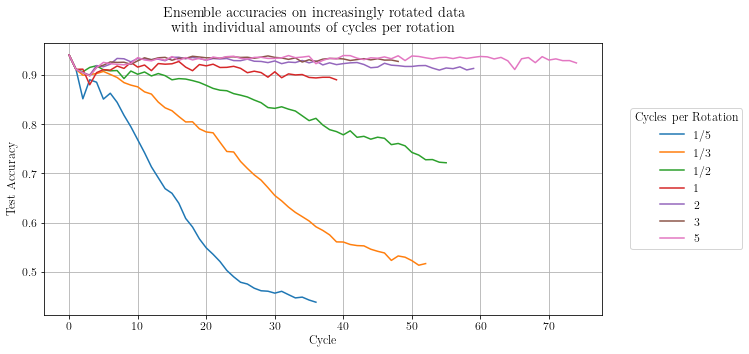

In [5]:
utils.plot_multiple_ensemble_accuracies(files, "Increment", xlim=None)

### Let's compare the viable augmentation speeds closer

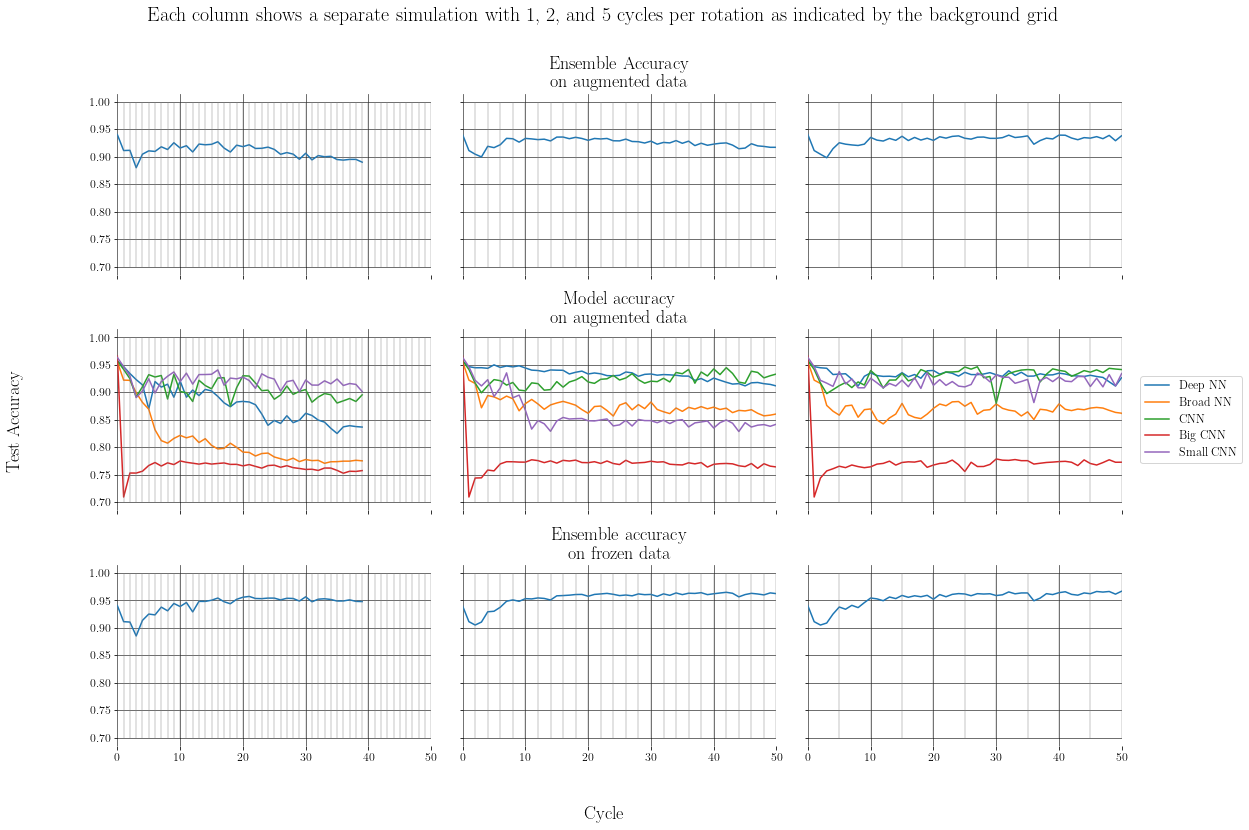

In [7]:
utils.plot_cycle_accuracies_grid(files[3:-2] + [files[-1]])

**Continuous ensemble training allows for stable performance in a changing environment whithout a decrease in performance on the original data.**

## What if there is less or more data per cycle?

In [1]:
paths = ["Increment_r90_e1_b1_c90_d15000",
         "datapercyclecomparison_r20_e1_b1_c100_d3000",
         "lessdata_r50_e1_b1_c250_d5000",
         "lessdata_r50_e1_b1_c250_d10000",
         "Increment_r180_e1_b1_c900_d15000"]

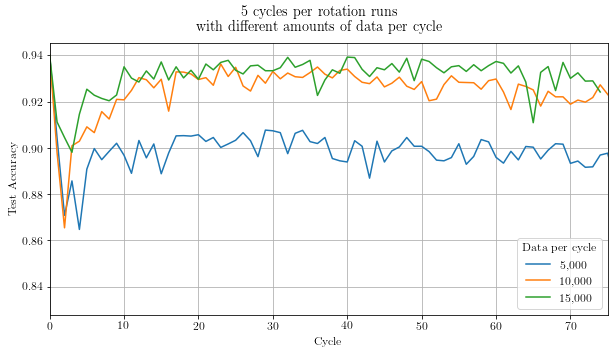

In [150]:
utils.plot_multiple_ensemble_accuracies(paths[2:], "5cr_comparison", xlim=75)

## What if the ratio is reversed?

/Users/floyd/Documents/Studium/BAE/continuous_training_using_ensemble_networks/notebooks/../lib/utils.py:655: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.arange(0,7,1))


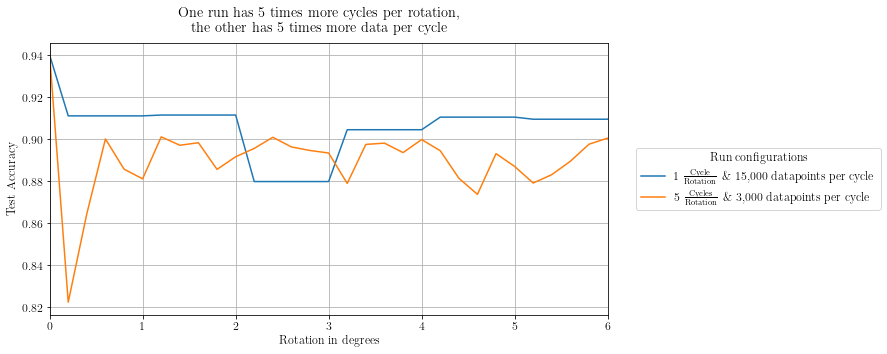

In [28]:
importlib.reload(utils)

utils.plot_multiple_ensemble_accuracies(paths[:2], "1cr15k_5cr3k", xlim=30)

## This also shows why working with a threshold does not work

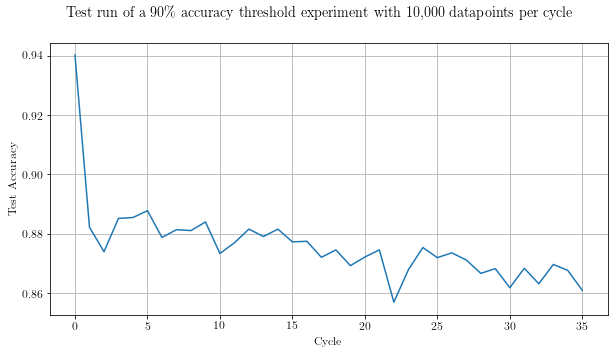

In [152]:
utils.plot_multiple_ensemble_accuracies(["accthresh_e1_b1_c180_t0.9_d10000"], which="threshold")

## What does the collected data show?

### $1 \frac{\text{Cycle}}{\text{Degree of rotation}}$

Cycle:  0


2022-05-17 16:56:38.424501: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


7701.0 collected datapoints labeled correct
328.0 collected datapoints were labeled wrong
544 datapoints were not classified.


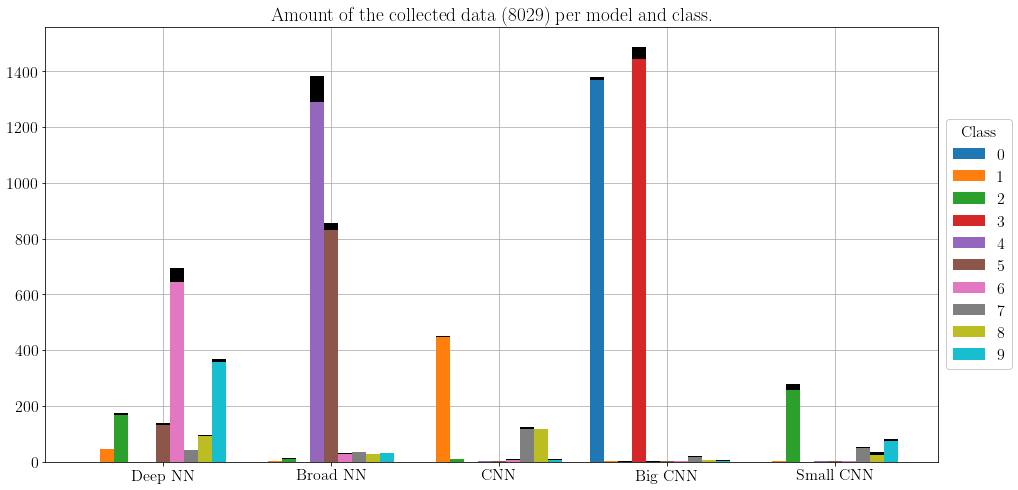

In [66]:
utils.plot_cycles_oneline(ensemble,
                          "Increment_r90_e1_b1_c90_d15000", only_some=[-2,-1])

Cycle:  0
5690.0 collected datapoints labeled correct
237.0 collected datapoints were labeled wrong
155 datapoints were not classified.


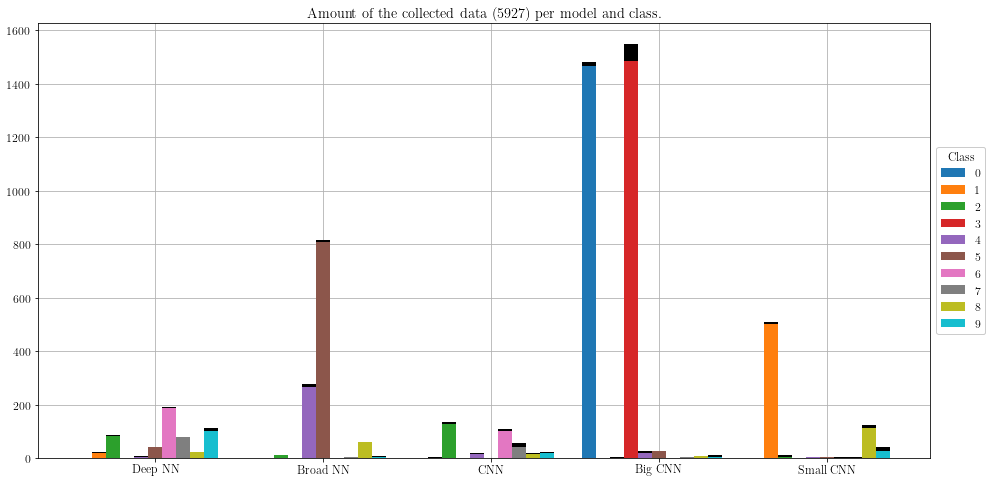

Cycle:  1
6088.0 collected datapoints labeled correct
252.0 collected datapoints were labeled wrong
207 datapoints were not classified.


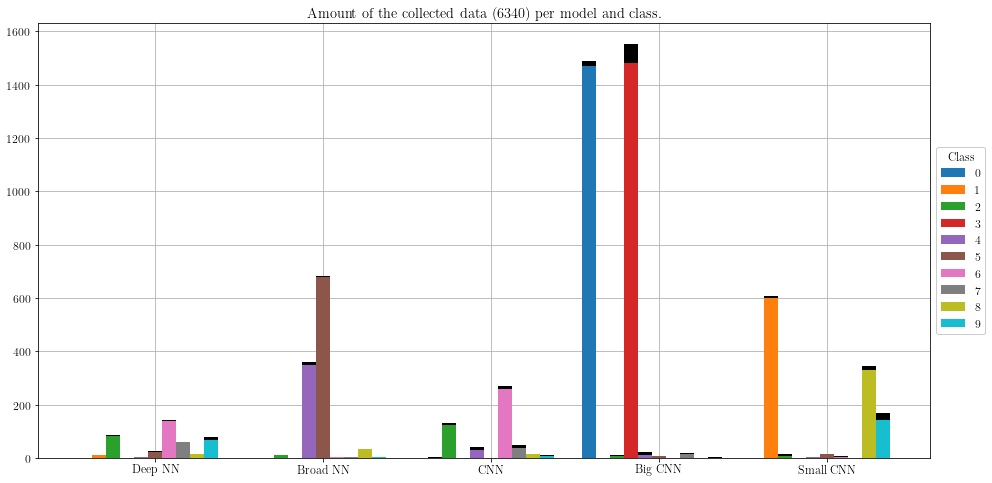

In [14]:
utils.plot_cycles_oneline(ensemble,
                          "Increment_r180_e1_b1_c900_d15000", only_some=[-4,-3,-2,-1])

Cycle:  0
254.0 collected datapoints labeled correct
52.0 collected datapoints were labeled wrong
194 datapoints were not classified.


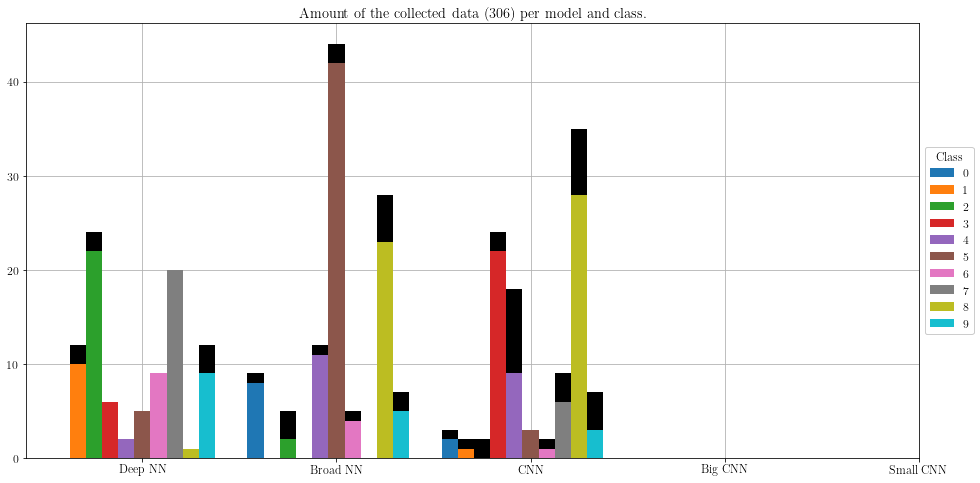

Cycle:  1
3918.0 collected datapoints labeled correct
119.0 collected datapoints were labeled wrong
695 datapoints were not classified.


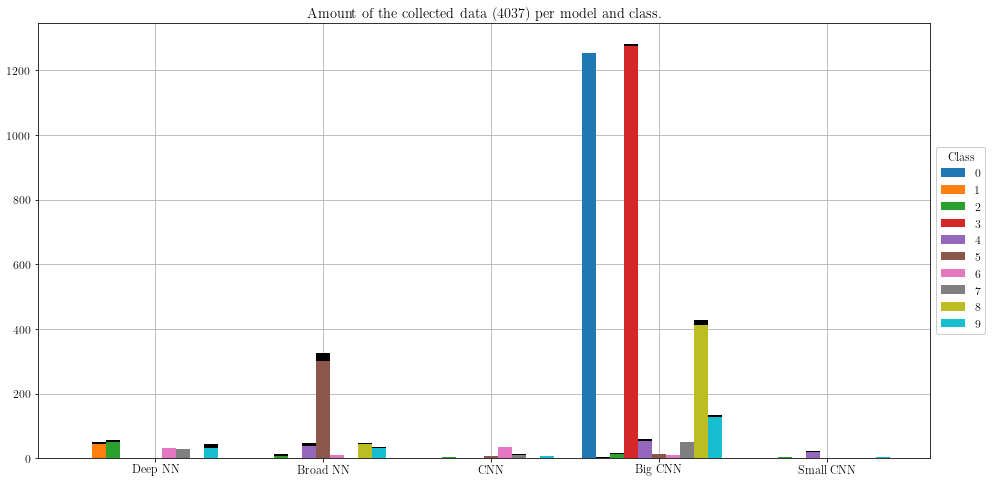

In [13]:
utils.plot_cycles_oneline(ensemble,
                          "Increment_r180_e1_b1_c900_d15000", only_some=range(4))

Cycle:  0
260.0 collected datapoints labeled correct
56.0 collected datapoints were labeled wrong
190 datapoints were not classified.


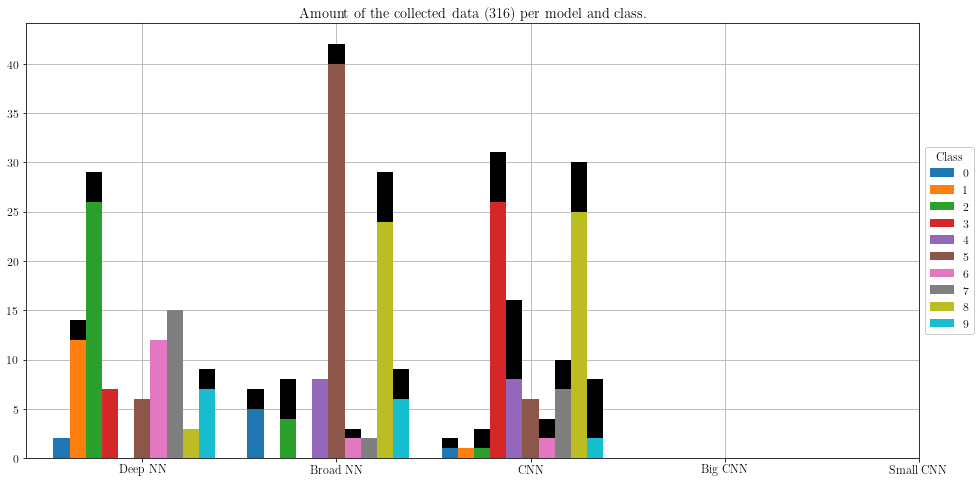

Cycle:  1
4494.0 collected datapoints labeled correct
103.0 collected datapoints were labeled wrong
1111 datapoints were not classified.


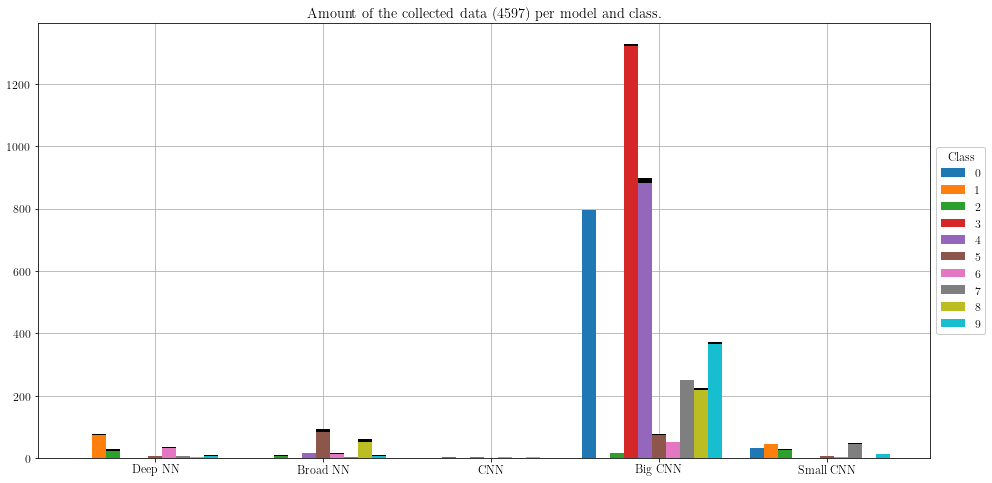

In [12]:
utils.plot_cycles_oneline(ensemble,
                          "Jump_r5_e1_b1_c24_d15000",
                          only_some=[0,1,2,3],
                          save=True)

### $2 \frac{\text{Cycles}}{\text{Degree of rotation}}$

Cycle:  0
6787.0 collected datapoints labeled correct
238.0 collected datapoints were labeled wrong
271 datapoints were not classified.


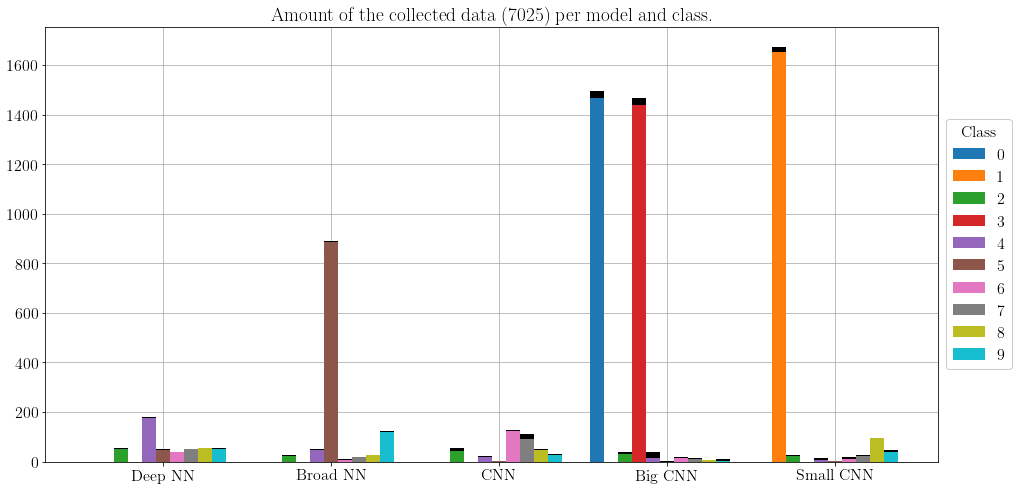

In [67]:
utils.plot_cycles_oneline(ensemble,
                          "Increment_r180_e1_b1_c360_d15000", only_some=[-2,-1])

### $3 \frac{\text{Cycles}}{\text{Degree of rotation}}$

Cycle:  0
5872.0 collected datapoints labeled correct
234.0 collected datapoints were labeled wrong
187 datapoints were not classified.


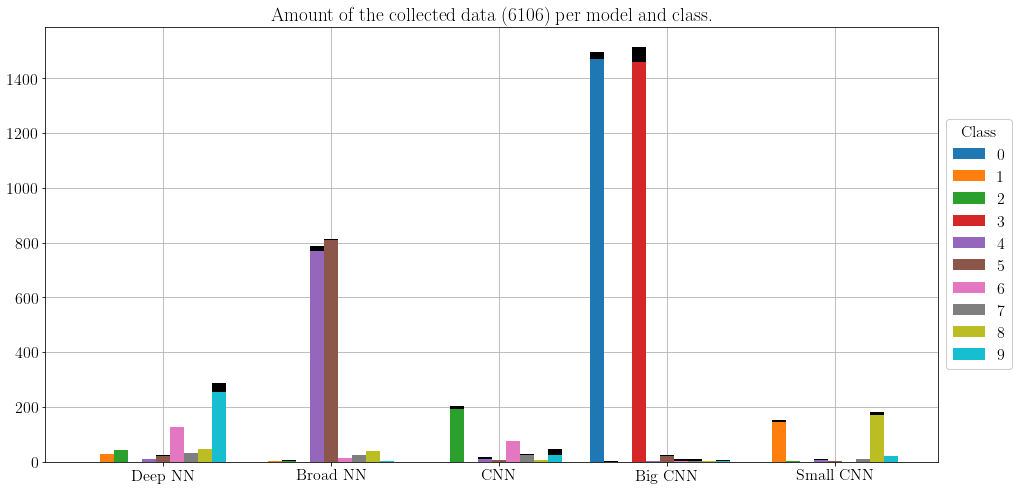

In [68]:
utils.plot_cycles_oneline(ensemble,
                          "Increment_r30_e1_b1_c90_d15000", only_some=[-2,-1])

## Can we evaluate the specialization?

2022-05-29 11:21:05.773285: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


ValueError: Shapes (3,) and (5,) are incompatible

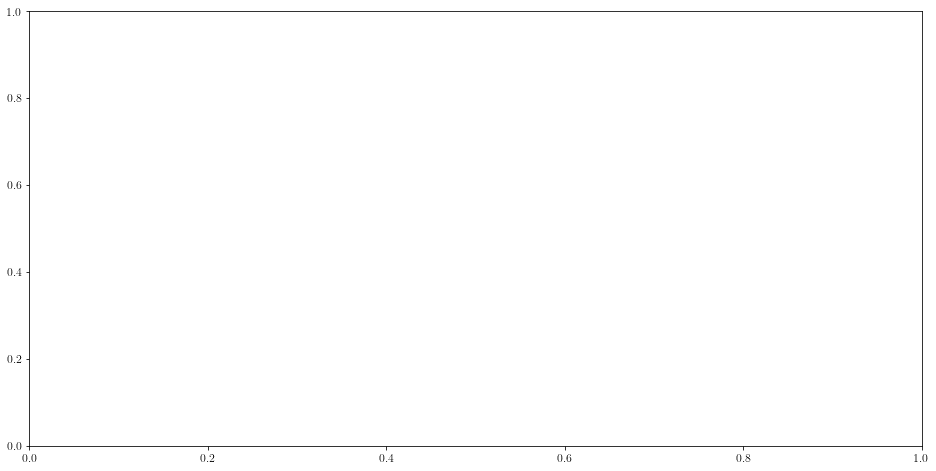

In [3]:
utils.classification_specialization_mean(ensemble,
                                         ["Jump_r5_e1_b1_c24_d15000"],
                                          legend=["1"])